# [POC] Compute Composite Metrics - Labour Progression

This dataset contains **2126** records of features extracted from Cardiotocogram exams, which were then classified by three expert obstetritians into 3 classes:

1. Normal
2. Suspect
3. Pathological

The dataset is obtained from [Kaggle.com](https://www.kaggle.com/), an online machine learning community.

Link to the dataset is [Here](https://www.kaggle.com/datasets/andrewmvd/fetal-health-classification?resource=download)

## **1. Importing Packages**

In [2]:
# General Python imports
import os
import gc
import time
import tqdm
import random

os.environ['KERAS_BACKEND'] = 'tensorflow'

import numpy as np
import pandas as pd

# Visualisation imports
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import warnings
warnings.filterwarnings('ignore')     

# Machine Learning libraries
from sklearn import preprocessing
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [3]:
for dirname, _, filenames in os.walk('input'):
    for filename in filenames:
        FILE_PATH = os.path.join(dirname, filename)
        print(FILE_PATH)

input/fetal_health_labour_progression.csv
input/fetal_health.csv


## **2. Data**

### 2.1 Loading the Data

In [4]:
data = pd.read_csv(FILE_PATH)
data.head()

,baseline value,accelerations,fetal_movement,uterine_contractions,light_decelerations,severe_decelerations,prolongued_decelerations,abnormal_short_term_variability,mean_value_of_short_term_variability,percentage_of_time_with_abnormal_long_term_variability,...,histogram_min,histogram_max,histogram_number_of_peaks,histogram_number_of_zeroes,histogram_mode,histogram_mean,histogram_median,histogram_variance,histogram_tendency,fetal_health
0,120.0,0.000,0.0,0.000,0.000,0.0,0.0,73.0,0.5,43.0,...,62.0,126.0,2.0,0.0,120.0,137.0,121.0,73.0,1.0,2.0
1,132.0,0.006,0.0,0.006,0.003,0.0,0.0,17.0,2.1,0.0,...,68.0,198.0,6.0,1.0,141.0,136.0,140.0,12.0,0.0,1.0
2,133.0,0.003,0.0,0.008,0.003,0.0,0.0,16.0,2.1,0.0,...,68.0,198.0,5.0,1.0,141.0,135.0,138.0,13.0,0.0,1.0
3,134.0,0.003,0.0,0.008,0.003,0.0,0.0,16.0,2.4,0.0,...,53.0,170.0,11.0,0.0,137.0,134.0,137.0,13.0,1.0,1.0
4,132.0,0.007,0.0,0.008,0.000,0.0,0.0,16.0,2.4,0.0,...,53.0,170.0,9.0,0.0,137.0,136.0,138.0,11.0,1.0,1.0


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2126 entries, 0 to 2125
Data columns (total 22 columns):
 #   Column                                                  Non-Null Count  Dtype  
---  ------                                                  --------------  -----  
 0   baseline value                                          2126 non-null   float64
 1   accelerations                                           2126 non-null   float64
 2   fetal_movement                                          2126 non-null   float64
 3   uterine_contractions                                    2126 non-null   float64
 4   light_decelerations                                     2126 non-null   float64
 5   severe_decelerations                                    2126 non-null   float64
 6   prolongued_decelerations                                2126 non-null   float64
 7   abnormal_short_term_variability                         2126 non-null   float64
 8   mean_value_of_short_term_variability  

### 2.2 Data Preprocessing

Scale the data using `StandardScaler`. 
* This is important because PCA is affected by the scale of the features.
* By standardising the data, we ensure that each feature contributes equally to the analysis and we can capture the true underlying patterns in the dataset.


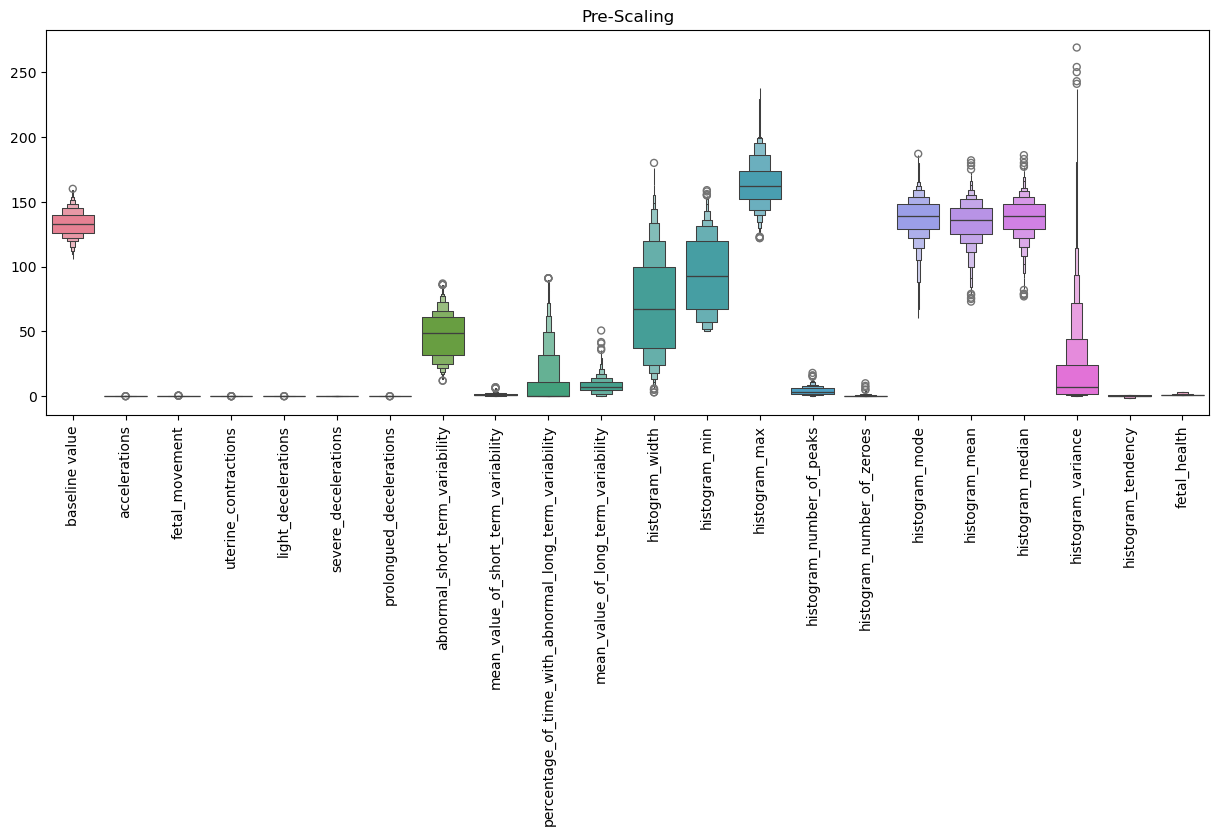

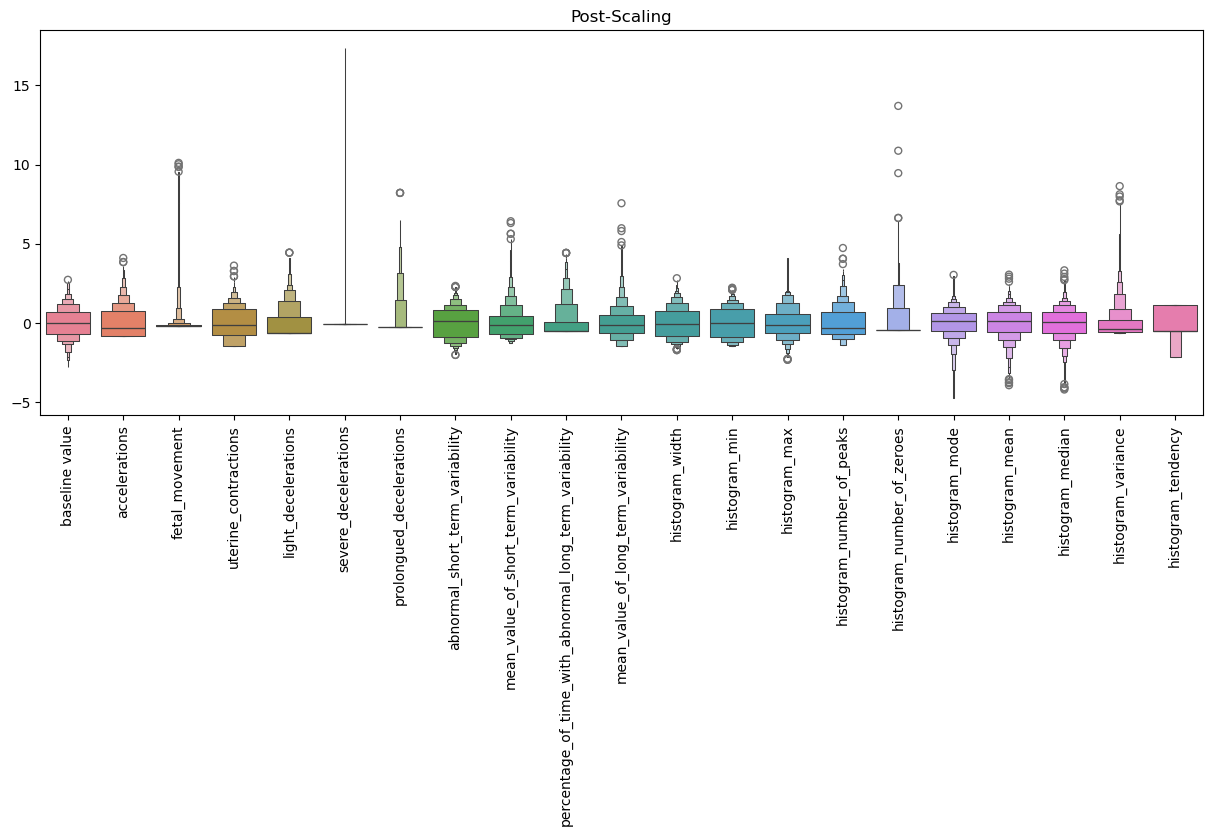

In [6]:
# Scaling data
scaler = StandardScaler()
X = data.drop(columns=["fetal_health"]) # Take only the features

plt.figure(figsize=(15,5))
sns.boxenplot(data =data)
plt.xticks(rotation=90)
plt.title("Pre-Scaling")
plt.show()

#Set up a standard scaler for the features
col_names = list(X.columns)
s_scaler = preprocessing.StandardScaler()
X_df= s_scaler.fit_transform(X)
X_df = pd.DataFrame(X_df, columns=col_names)   
X_df.describe().T

# Display scaled features
plt.figure(figsize=(15,5))
sns.boxenplot(data = X_df)
plt.xticks(rotation=90)
plt.title("Post-Scaling")
plt.show()

## 3. Apply PCA

We apply PCA to reduce the dimensionality of our data. 
* PCA transforms the dataset into a set of orthogonal components that capture the most variance
* This is an attempt to arrive at a composite parameter through simplifying our dataset while retaining its core characteristics.

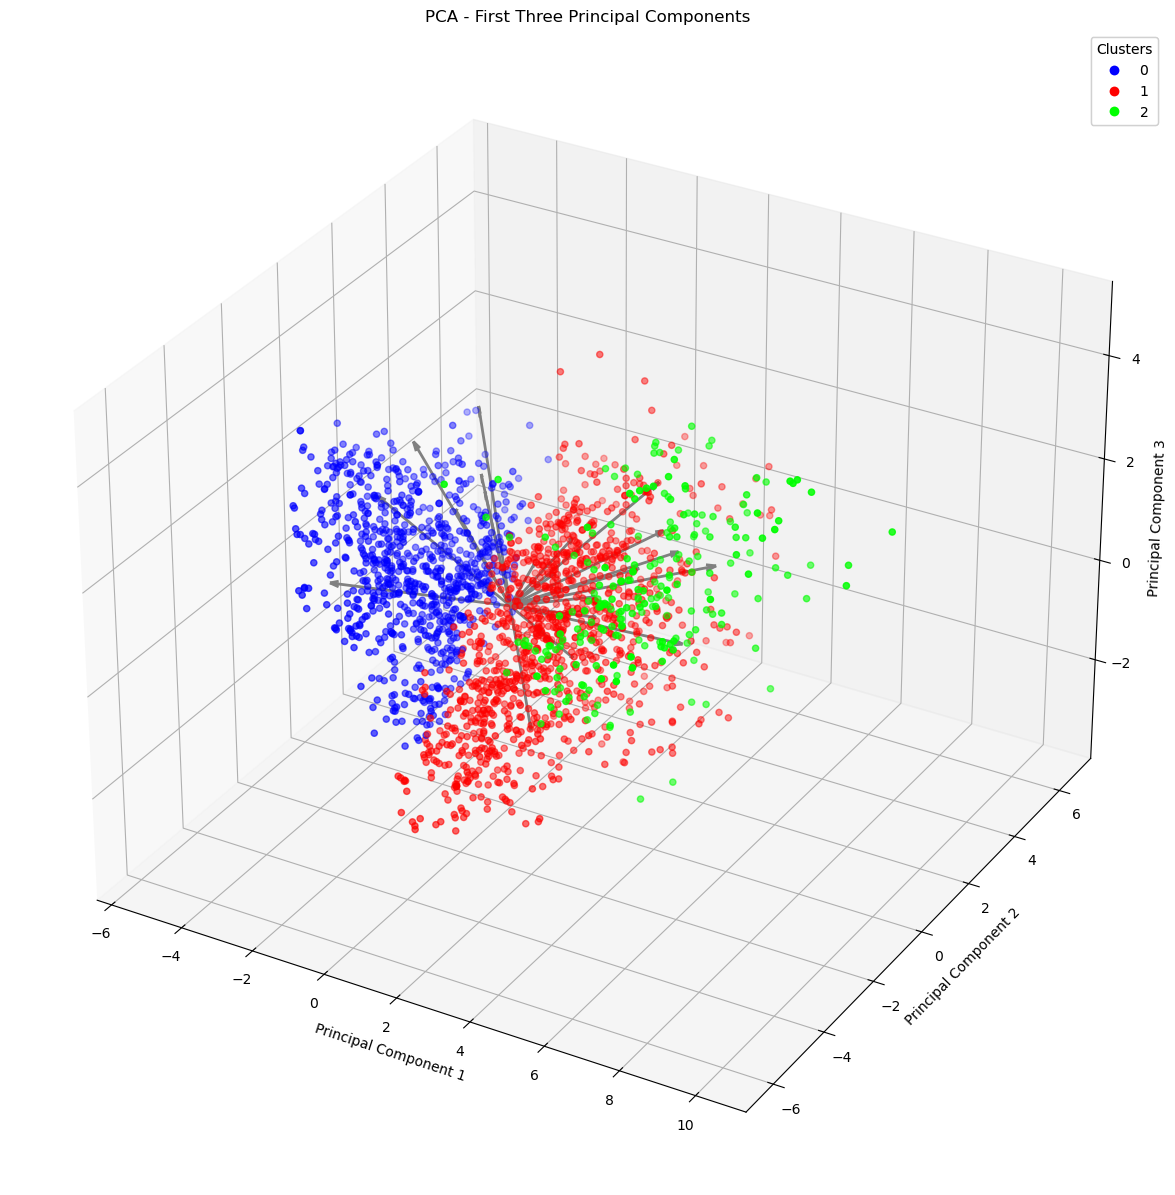

In [7]:
pca = PCA(n_components=None)
principal_components = pca.fit_transform(X_df)
loadings = pca.components_.T * np.sqrt(pca.explained_variance_)

# Clustering
kmeans = KMeans(n_clusters=3)
cluster_labels = kmeans.fit_predict(X_df)

# Visualisation
fig = plt.figure(figsize=(15, 15))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(principal_components[:, 0], principal_components[:, 1], principal_components[:, 2], c=cluster_labels, cmap="brg")

for i in range(len(loadings)):
    ax.quiver(0, 0, 0, loadings[i, 0], loadings[i, 1], loadings[i, 2], color="gray", length=5, linewidths=2, arrow_length_ratio=0.05)

# Legend and titles
legend1 = ax.legend(*scatter.legend_elements(), loc="upper right", title="Clusters")
ax.add_artist(legend1)

ax.set_title('PCA - First Three Principal Components')
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_zlabel('Principal Component 3')
plt.show()

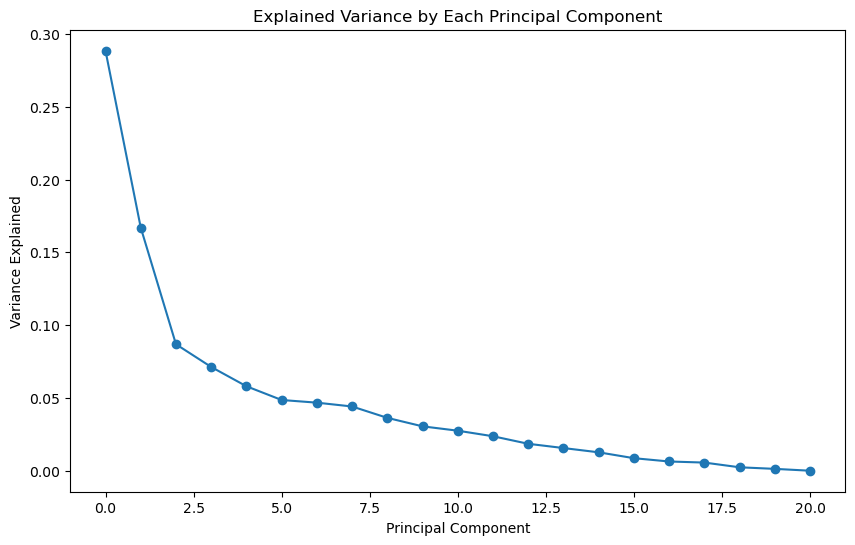

In [13]:
plt.figure(figsize=(10, 6))
plt.plot(pca.explained_variance_ratio_, marker='o')
plt.title('Explained Variance by Each Principal Component')
plt.xlabel('Principal Component')
plt.ylabel('Variance Explained')
plt.show()

In [8]:
data['labour_progression'] = principal_components[:, 0]
data.head()

,baseline value,accelerations,fetal_movement,uterine_contractions,light_decelerations,severe_decelerations,prolongued_decelerations,abnormal_short_term_variability,mean_value_of_short_term_variability,percentage_of_time_with_abnormal_long_term_variability,...,histogram_max,histogram_number_of_peaks,histogram_number_of_zeroes,histogram_mode,histogram_mean,histogram_median,histogram_variance,histogram_tendency,fetal_health,labour_progression
0,120.0,0.000,0.0,0.000,0.000,0.0,0.0,73.0,0.5,43.0,...,126.0,2.0,0.0,120.0,137.0,121.0,73.0,1.0,2.0,-0.263977
1,132.0,0.006,0.0,0.006,0.003,0.0,0.0,17.0,2.1,0.0,...,198.0,6.0,1.0,141.0,136.0,140.0,12.0,0.0,1.0,1.954458
2,133.0,0.003,0.0,0.008,0.003,0.0,0.0,16.0,2.1,0.0,...,198.0,5.0,1.0,141.0,135.0,138.0,13.0,0.0,1.0,1.971485
3,134.0,0.003,0.0,0.008,0.003,0.0,0.0,16.0,2.4,0.0,...,170.0,11.0,0.0,137.0,134.0,137.0,13.0,1.0,1.0,2.222056
4,132.0,0.007,0.0,0.008,0.000,0.0,0.0,16.0,2.4,0.0,...,170.0,9.0,0.0,137.0,136.0,138.0,11.0,1.0,1.0,1.785438


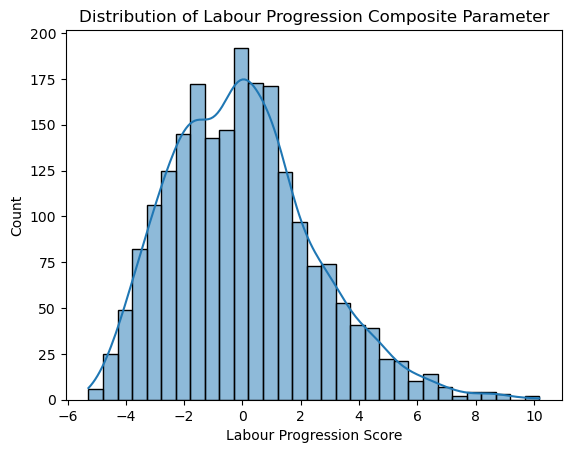

In [9]:
sns.histplot(data['labour_progression'], kde=True)
plt.title('Distribution of Labour Progression Composite Parameter')
plt.xlabel('Labour Progression Score')
plt.show()

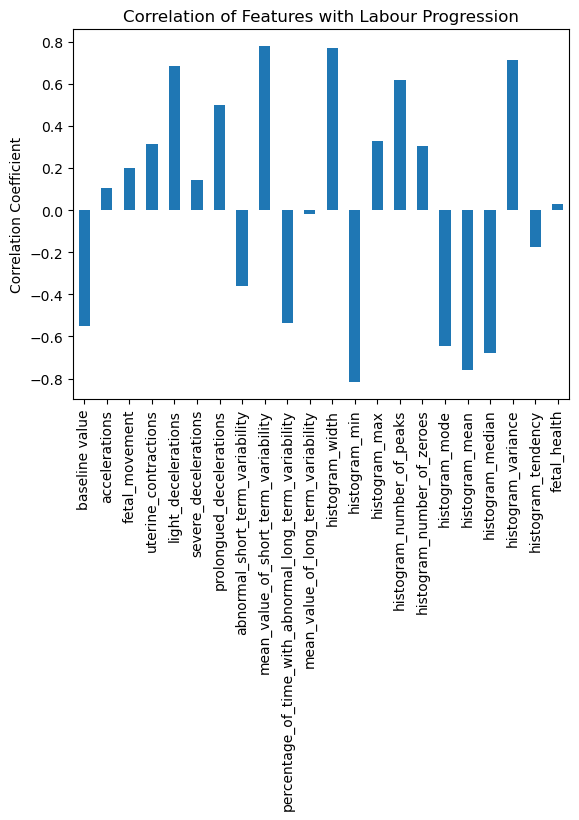

In [10]:
# Calculate correlation with labour_progression
corr_lb = data.corr()['labour_progression'].drop('labour_progression')  # exclude self-correlation
corr_lb.plot(kind='bar')
plt.title('Correlation of Features with Labour Progression')
plt.ylabel('Correlation Coefficient')
plt.show()

<Axes: >

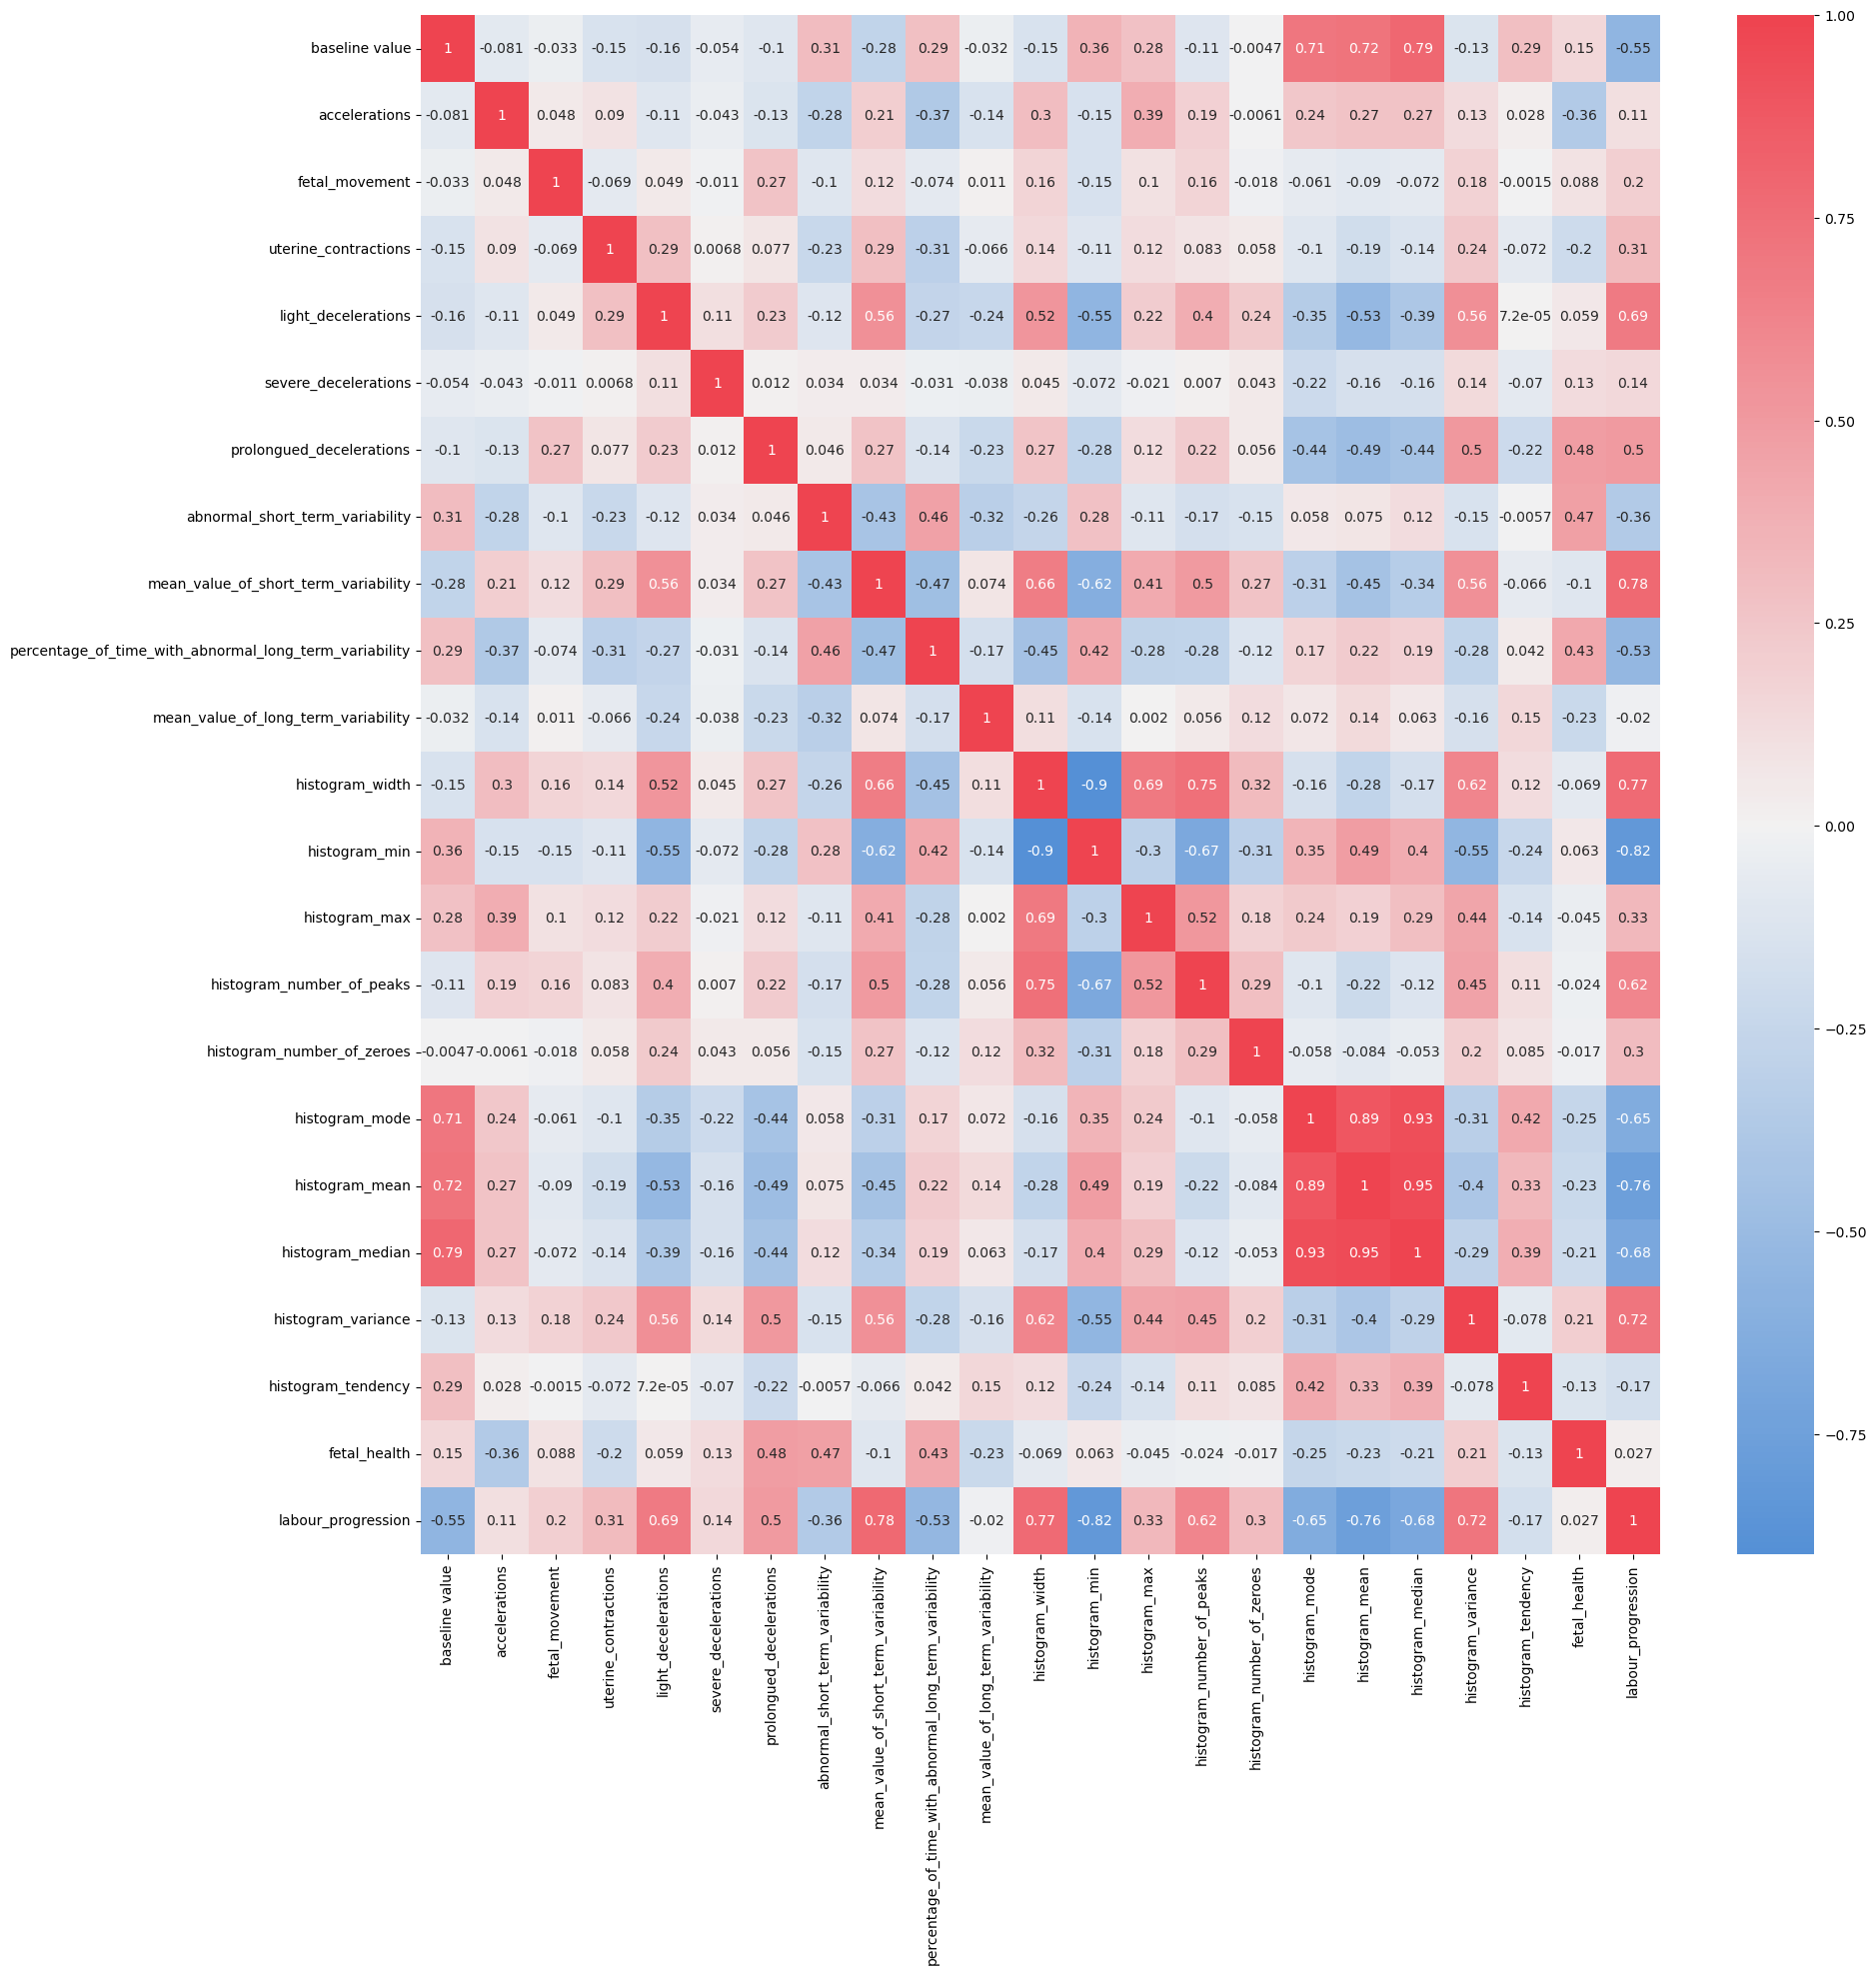

In [11]:
# Correlation matrix
corrmat= data.corr()
plt.figure(figsize=(20,20))  

cmap = sns.diverging_palette(250, 10, s=80, l=55, n=9, as_cmap=True)

sns.heatmap(corrmat,annot=True, cmap=cmap, center=0)

### 4. Export Dataset

In [12]:
data.to_csv("/Users/evanyan13/2024/EG3301R/fetu/proof_of_concept/input/fetal_health_labour_progression.csv", index=False)